In [24]:
# Import necessary libraries
import tensorflow as tf  # Deep learning framework
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # For image loading and augmentation
import matplotlib.pyplot as plt  # For plotting training progress
import os  # For accessing files and directories

In [ ]:
# Define paths to training and validation datasets
train_path = "Synthetic_Drone_Classification_Dataset/train" # This one is for training data
val_path = "Synthetic_Drone_Classification_Dataset/val" # And this one is to see how well the model performs with new images

# Set up data generators with augmentation for training, only rescaling for validation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values between 0 and 1
    rotation_range=20,  # Random rotation
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True  # Random horizontal flip
)

val_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for validation

# Load training images from folders, automatically labeling them based on folder names
train_generator = train_datagen.flow_from_directory(
    train_path, 
    target_size=(128, 128),  # Resize all images to 128x128
    batch_size=32, # Loading 32 images at a time
    class_mode='categorical'  # Multi-class classification
)

# Load validation images - the same as above but for the validation set
val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

# Show class labels detected from folder names
print("Train classes:", train_generator.class_indices)

Found 4001 images belonging to 4 classes.
Found 4000 images belonging to 4 classes.
Train classes: {'dji_inspire': 0, 'dji_mavic': 1, 'dji_phantom': 2, 'no_drone': 3}


In [26]:
# Load the MobileNetV2 model without the top classifier layer
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(128, 128, 3),  # Input shape (H, W, Channels)
    include_top=False,  # Exclude the final dense layers
    weights='imagenet'  # Load pre-trained weights from ImageNet
)
base_model.trainable = False  # Freeze the base model to prevent its weights from updating

# Build a new classifier on top of the base model
model = tf.keras.Sequential([
    base_model,  # Feature extractor
    tf.keras.layers.GlobalAveragePooling2D(),  # Reduce feature maps to a single vector per sample
    tf.keras.layers.Dropout(0.3),  # Prevent overfitting
    tf.keras.layers.Dense(4, activation='softmax')  # Output layer for 4 categories
])

# Compile the model
model.compile(
    optimizer='adam',  # Adaptive learning rate optimizer
    loss='categorical_crossentropy',  # Appropriate for multi-class classification
    metrics=['accuracy']  # Track accuracy during training
)

In [27]:
# Train the model for 10 epochs
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

Epoch 1/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 29s 221ms/step - accuracy: 0.6144 - loss: 0.9814 - val_accuracy: 0.8698 - val_loss: 0.3593
Epoch 2/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 27s 212ms/step - accuracy: 0.8888 - loss: 0.3001 - val_accuracy: 0.8715 - val_loss: 0.3385
Epoch 3/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 27s 212ms/step - accuracy: 0.9055 - loss: 0.2515 - val_accuracy: 0.9240 - val_loss: 0.2255
Epoch 4/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 27s 212ms/step - accuracy: 0.9326 - loss: 0.2023 - val_accuracy: 0.9320 - val_loss: 0.2012
Epoch 5/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 27s 213ms/step - accuracy: 0.9350 - loss: 0.1903 - val_accuracy: 0.9298 - val_loss: 0.2001
Epoch 6/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 27s 214ms/step - accuracy: 0.9359 - loss: 0.1675 - val_accuracy: 0.9410 - val_loss: 0.1750
Epoch 7/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 27s 214ms/step - accuracy: 0.9443 - loss: 0.1547 - val_accuracy: 0.9423 - val_loss: 0.1751
Epoch 8/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 27s 214ms/step - accuracy: 0.9455 - loss: 0

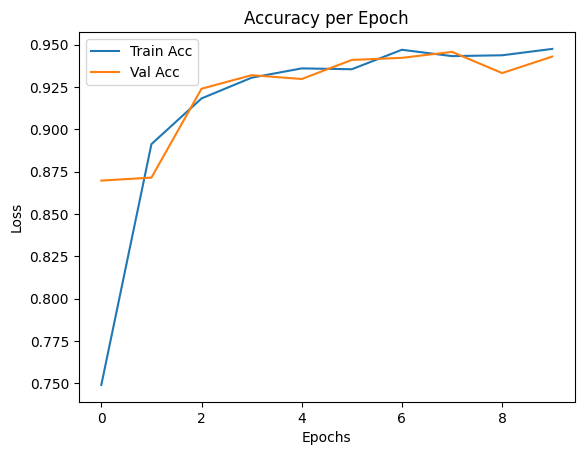

In [ ]:
# Plot training and validation accuracy over time
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [29]:
# Evaluate model performance on the validation set
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - accuracy: 0.9431 - loss: 0.1673
Validation Accuracy: 94.30%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
 This image does not clearly belong to any known class.


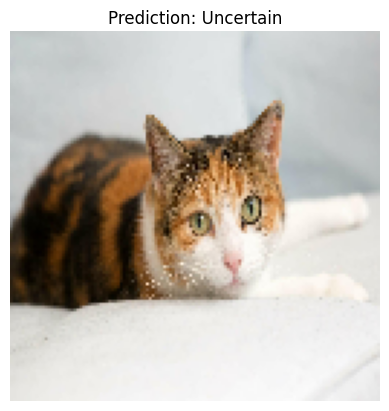

In [45]:
import numpy as np  # Import NumPy for array operations
from tensorflow.keras.preprocessing import image  # Image loading & preprocessing
import matplotlib.pyplot as plt  # For optional visualization

# Load and preprocess the image
img = image.load_img("cat.jpg", target_size=(128, 128))  # Load image and resize to match model input
img_array = image.img_to_array(img) / 255.0  # Convert to array and normalize pixel values
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension (1, 128, 128, 3)

# Predict class probabilities
prediction = model.predict(img_array)  # Predict class probabilities using the trained model
probs = prediction[0]  # Get the prediction for the single image

# Get class labels from training data
class_labels = list(train_generator.class_indices.keys())  # ['dji_inspire', 'dji_mavic', 'dji_phantom', 'no_drone']

# Apply threshold logic
if max(probs) < 0.5:
    print(" This image does not clearly belong to any known class.")
    predicted_class = "Uncertain"
else:
    predicted_class = class_labels[np.argmax(probs)]
    print(f"Predicted: {predicted_class} ({max(probs)*100:.2f}%)")

# Optional: Show the image with prediction
plt.imshow(img)
plt.axis('off')
plt.title(f"Prediction: {predicted_class}")
plt.show()
